### 矢量数据与栅格数据相互转换


In [3]:
import geopandas as gpd
import rasterio as rio
from rasterio import features    ### 需要单独导入
import matplotlib.pyplot as plt
import numpy as np


In [4]:
path_vec = 'data/data-section-5/subset_2_water.gpkg'
path_base_raster = 'data/data-section-5/subset_2.tif'

   number                                           geometry
0       1  MULTIPOLYGON (((279670.285 2754921.390, 279714...
1       2  MULTIPOLYGON (((282816.290 2753657.755, 282999...
2       3  MULTIPOLYGON (((281052.560 2747835.801, 281238...
3       4  MULTIPOLYGON (((286833.384 2754476.277, 287013...


/Users/luo/miniconda3/envs/venv/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<Axes: >

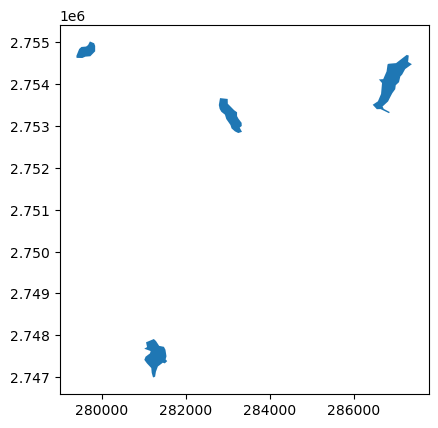

In [12]:
vec_gpd = gpd.read_file(path_vec)
print(vec_gpd.head())
vec_gpd.plot()


In [6]:
geos = []
for geo in vec_gpd.geometry:
    geos.append(geo)
geos

[<MULTIPOLYGON (((279670.285 2754921.39, 279714.6 2755007.559, 279815.542 275...>,
 <MULTIPOLYGON (((282816.29 2753657.755, 282999.521 2753637.714, 283002.384 2...>,
 <MULTIPOLYGON (((281052.56 2747835.801, 281238.845 2747914.39, 281289.782 27...>,
 <MULTIPOLYGON (((286833.384 2754476.277, 287013.945 2754491.753, 287266.729 ...>]

In [8]:
raster = rio.open(path_base_raster)
print(raster.bounds)
print(raster.res)
raster.meta


BoundingBox(left=273060.0, bottom=2744880.0, right=292160.0, top=2757940.0)
(20.0, 20.0)


{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 955,
 'height': 653,
 'count': 6,
 'crs': CRS.from_epsg(32648),
 'transform': Affine(20.0, 0.0, 273060.0,
        0.0, -20.0, 2757940.0)}

In [7]:
rasterized_1 = features.rasterize(shapes=geos,
                                out_shape = raster.shape,    ## 此处.shape获取二维形状
                                fill = 0,
                                out = None,
                                transform = raster.transform,
                                default_value = 1,
                                dtype = None)


可视化栅格化结果

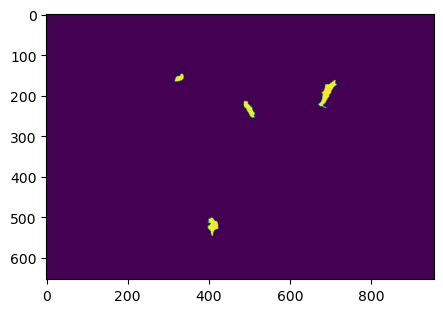

In [8]:
fig, ax = plt.subplots(1,1, figsize = (5, 5))
ax.imshow(rasterized_1)


根据矢量数据属性值进行栅格化

In [9]:
geos_values = zip(list(vec_gpd['geometry']), list(vec_gpd['number']))
geos_values = list(geos_values)
# Rasterize vector using the shape and transform of the raster
rasterized_2 = features.rasterize(shapes=geos_values,
                                out_shape = raster.shape,
                                transform = raster.transform,
                                all_touched = True,
                                fill = 0,   # background value
                                # merge_alg = MergeAlg.replace,
                                dtype = None)

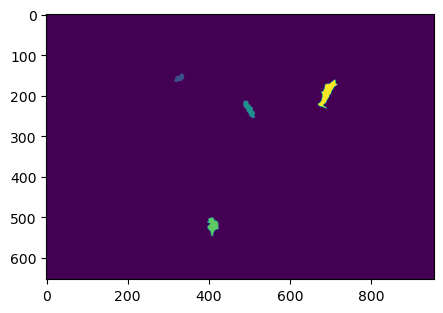

In [10]:
fig, ax = plt.subplots(1,1, figsize = (5, 5))
ax.imshow(rasterized_2)


写出栅格化数据

In [15]:
path_out = 'data/data-section-5/subset_2_water_rasterize2_python.tif'
with rio.open(path_out, 'w', driver=raster.driver, 
                   height=raster.height,
                   width=raster.width,
                   count=1,
                   dtype=np.int16,
                   crs=raster.crs,
                   transform=raster.transform) as dst:
  dst.write(rasterized_2, 1)    ## the number 1 is the number of bands.


gdal命令行工具   
1. 矢量转栅格
gdal_rasterize: https://gdal.org/programs/gdal_rasterize.html


In [13]:
path_vec = 'data/data-section-5/subset_2_water.gpkg'
path_out = 'data/data-section-5/subset_2_water_rasterize2_gdal.tif'
# !gdal_rasterize -tr 20 20 -burn 1 $path_vec $path_out
# !gdal_rasterize -tr 20 20 -burn 1 $path_vec $path_out -te 273060.0, 2744880.0, 292160.0, 2757940.0
!gdal_rasterize -tr 20 20 -a number $path_vec $path_out -te 273060.0, 2744880.0, 292160.0, 2757940.0


0...10...20...30...40...50...60...70...80...90...100 - done.


2. 栅格转矢量   
 gdal_polygonize: https://gdal.org/programs/gdal_polygonize.html

In [16]:
path_raster = 'data/data-section-5/subset_2_water_rasterize2_gdal.tif'
path_out = 'data/data-section-5/subset_2_water_polygonize_gdal.gpkg'
!gdal_polygonize.py -overwrite $path_raster $path_out


Creating output data/data-section-5/subset_2_water_polygonize_gdal.gpkg of format GPKG.
0...10...20...30...40...50...60...70...80...90...100 - done.
